# Loading data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import tqdm.auto

In [2]:
from msm_we import msm_we
import mdtraj as md

In [3]:
#ray.shutdown()

In [4]:
import ray
ray.init()

2024-02-12 05:32:13,711	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.11
Ray version:,2.4.0
Dashboard:,http://127.0.0.1:8265


In [5]:
import logging
from rich.logging import RichHandler
log = logging.getLogger()
log.addHandler(RichHandler())

msm_log = logging.getLogger("msm_we.msm_we")

In [6]:
logging.getLogger('msm_we.msm_we').setLevel('DEBUG')

In [7]:
import westpa
from westpa.core.binning import RectilinearBinMapper

In [8]:
def processCoordinates(self, coords):
#     log.debug("Processing coordinates")

    if self.dimReduceMethod == "none":
        xt = md.Trajectory(xyz=coords, topology=None)
        indCA = self.reference_structure.topology.select("name CA")
        indAlign = self.reference_structure.topology.select("name CA")
        x2 = xt.superpose(self.reference_structure,atom_indices=indAlign)
        coords = x2._xyz.astype('float64')
        nA = np.shape(indCA)[0]
        nC = np.shape(coords)[0]
        new_coords = coords[:,tuple(indCA),:]
        #new_coords = np.double(new_coords)
        #new_coords = coords[:, :923, :]
        data = new_coords.reshape(nC, 3 * nA)
        model.nAtoms = nA
        return data

    if self.dimReduceMethod == "pca" or self.dimReduceMethod == "vamp":

        # Dimensionality reduction

        xt = md.Trajectory(xyz=coords, topology=None)
        #indCA = self.reference_structure.topology.select("not type H and (resid 5 to 17 or resid 23 to 35 
        #or resid 40 to 53)")
        indCA = self.reference_structure.topology.select("name CA")
        pair1, pair2 = np.meshgrid(indCA, indCA, indexing="xy")
        indUT = np.where(np.triu(pair1, k=1) > 0)
        pairs = np.transpose(np.array([pair1[indUT], pair2[indUT]])).astype(int)
        dist = md.compute_distances(xt, pairs, periodic=True, opt=True)

        return dist
    
msm_we.modelWE.processCoordinates = processCoordinates

## Build block-wise haMSMs

##### Build the model

In [9]:
pwd

'/home/marion_lab/Documents/HIF/hamsm/CompleteData_2Dpcoord/NewTest_PStoContactMap'

In [11]:
h5_glob = ['/media/extHDD/mls333/h5Files_1D_RMSD/data_pcoordRMSD/west_reduced_run1_1Dpcoord_RMSD_complete.h5',
           '/media/extHDD/mls333/h5Files_1D_RMSD/data_pcoordRMSD/west_reduced_run2_1Dpcoord_RMSD_complete.h5',
           '/media/extHDD/mls333/h5Files_1D_RMSD/data_pcoordRMSD/west_reduced_run3_1Dpcoord_RMSD_complete.h5']

model =  msm_we.modelWE()
model.initialize(
    fileSpecifier=h5_glob, 
    refPDBfile = '../../ref_strip.pdb',
    modelName = 'HIF2a',
    target_pcoord_bounds = [[15.0, np.inf]],
    basis_pcoord_bounds  = [[0.0, 3.0]],
    dim_reduce_method = 'none',
    tau = 1e-10,
    pcoord_ndim = 1, 
)

model.get_iterations()
model.get_coordSet(model.maxIter)
#model.get_traj_coordinates(from_iter=1.1:8265 , traj_le)

Getting coordSet ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 0:27:28

In [11]:
#h5_glob = ['west_reduced_run1.h5',]
##h5_glob = ['restart3_scikit_nowat/run1/west.h5','restart3_scikit_nowat/run2/west.h5',
#'restart3_scikit_nowat/run3/west.h5']

#model =  msm_we.modelWE()
#model.initialize(
#    fileSpecifier=h5_glob, 
#    refPDBfile = '../ref_strip.pdb',
#    modelName = 'HIF2a',
#    target_pcoord_bounds = [[300.0, np.inf], [10.0, np.inf], [10.0, np.inf]],
#    basis_pcoord_bounds  = [[0.0, 280.], [0.0, 2.0], [0.0, 3.0]],
#    dim_reduce_method = 'none',
#    tau = 1e-10,
#    pcoord_ndim = 3, 
#)

#model.get_iterations()
#model.get_coordSet(model.maxIter)
#model.get_traj_coordinates(from_iter=1.1:8265 , traj_le)

Output()

##### PCA on all the data

In [12]:
model.dimReduce()

In [13]:
# For saving the clustered model data
from pickle import dump
with open('check1_T15ARMSD.pickle', 'wb') as fo:
    dump(model, fo)

In [9]:
# For loading the clustered model data
from pickle import load
with open('check1_T15ARMSD.pickle', 'rb') as fo:
    model = load(fo)

In [10]:
model.maxIter

1000

##### Cluster on all the data, and store the original clustering.

In [11]:
0.03125/2

0.015625

In [11]:
a3=np.arange(12,15,0.01)
a3,a3.shape

(array([12.  , 12.01, 12.02, 12.03, 12.04, 12.05, 12.06, 12.07, 12.08,
        12.09, 12.1 , 12.11, 12.12, 12.13, 12.14, 12.15, 12.16, 12.17,
        12.18, 12.19, 12.2 , 12.21, 12.22, 12.23, 12.24, 12.25, 12.26,
        12.27, 12.28, 12.29, 12.3 , 12.31, 12.32, 12.33, 12.34, 12.35,
        12.36, 12.37, 12.38, 12.39, 12.4 , 12.41, 12.42, 12.43, 12.44,
        12.45, 12.46, 12.47, 12.48, 12.49, 12.5 , 12.51, 12.52, 12.53,
        12.54, 12.55, 12.56, 12.57, 12.58, 12.59, 12.6 , 12.61, 12.62,
        12.63, 12.64, 12.65, 12.66, 12.67, 12.68, 12.69, 12.7 , 12.71,
        12.72, 12.73, 12.74, 12.75, 12.76, 12.77, 12.78, 12.79, 12.8 ,
        12.81, 12.82, 12.83, 12.84, 12.85, 12.86, 12.87, 12.88, 12.89,
        12.9 , 12.91, 12.92, 12.93, 12.94, 12.95, 12.96, 12.97, 12.98,
        12.99, 13.  , 13.01, 13.02, 13.03, 13.04, 13.05, 13.06, 13.07,
        13.08, 13.09, 13.1 , 13.11, 13.12, 13.13, 13.14, 13.15, 13.16,
        13.17, 13.18, 13.19, 13.2 , 13.21, 13.22, 13.23, 13.24, 13.25,
      

In [12]:
new_mapper = RectilinearBinMapper([[0, 3.  ,  3.01,  3.02,  3.03,  3.04,  3.05,  3.06,  3.07,  3.08,
         3.09,  3.1 ,  3.11,  3.12,  3.13,  3.14,  3.15,  3.16,  3.17,
         3.18,  3.19,  3.2 ,  3.21,  3.22,  3.23,  3.24,  3.25,  3.26,
         3.27,  3.28,  3.29,  3.3 ,  3.31,  3.32,  3.33,  3.34,  3.35,
         3.36,  3.37,  3.38,  3.39,  3.4 ,  3.41,  3.42,  3.43,  3.44,
         3.45,  3.46,  3.47,  3.48,  3.49,  3.5 ,  3.51,  3.52,  3.53,
         3.54,  3.55,  3.56,  3.57,  3.58,  3.59,  3.6 ,  3.61,  3.62,
         3.63,  3.64,  3.65,  3.66,  3.67,  3.68,  3.69,  3.7 ,  3.71,
         3.72,  3.73,  3.74,  3.75,  3.76,  3.77,  3.78,  3.79,  3.8 ,
         3.81,  3.82,  3.83,  3.84,  3.85,  3.86,  3.87,  3.88,  3.89,
         3.9 ,  3.91,  3.92,  3.93,  3.94,  3.95,  3.96,  3.97,  3.98,
         3.99,  4.  ,  4.01,  4.02,  4.03,  4.04,  4.05,  4.06,  4.07,
         4.08,  4.09,  4.1 ,  4.11,  4.12,  4.13,  4.14,  4.15,  4.16,
         4.17,  4.18,  4.19,  4.2 ,  4.21,  4.22,  4.23,  4.24,  4.25,
         4.26,  4.27,  4.28,  4.29,  4.3 ,  4.31,  4.32,  4.33,  4.34,
         4.35,  4.36,  4.37,  4.38,  4.39,  4.4 ,  4.41,  4.42,  4.43,
         4.44,  4.45,  4.46,  4.47,  4.48,  4.49,  4.5 ,  4.51,  4.52,
         4.53,  4.54,  4.55,  4.56,  4.57,  4.58,  4.59,  4.6 ,  4.61,
         4.62,  4.63,  4.64,  4.65,  4.66,  4.67,  4.68,  4.69,  4.7 ,
         4.71,  4.72,  4.73,  4.74,  4.75,  4.76,  4.77,  4.78,  4.79,
         4.8 ,  4.81,  4.82,  4.83,  4.84,  4.85,  4.86,  4.87,  4.88,
         4.89,  4.9 ,  4.91,  4.92,  4.93,  4.94,  4.95,  4.96,  4.97,
         4.98,  4.99,  5.  ,  5.01,  5.02,  5.03,  5.04,  5.05,  5.06,
         5.07,  5.08,  5.09,  5.1 ,  5.11,  5.12,  5.13,  5.14,  5.15,
         5.16,  5.17,  5.18,  5.19,  5.2 ,  5.21,  5.22,  5.23,  5.24,
         5.25,  5.26,  5.27,  5.28,  5.29,  5.3 ,  5.31,  5.32,  5.33,
         5.34,  5.35,  5.36,  5.37,  5.38,  5.39,  5.4 ,  5.41,  5.42,
         5.43,  5.44,  5.45,  5.46,  5.47,  5.48,  5.49,  5.5 ,  5.51,
         5.52,  5.53,  5.54,  5.55,  5.56,  5.57,  5.58,  5.59,  5.6 ,
         5.61,  5.62,  5.63,  5.64,  5.65,  5.66,  5.67,  5.68,  5.69,
         5.7 ,  5.71,  5.72,  5.73,  5.74,  5.75,  5.76,  5.77,  5.78,
         5.79,  5.8 ,  5.81,  5.82,  5.83,  5.84,  5.85,  5.86,  5.87,
         5.88,  5.89,  5.9 ,  5.91,  5.92,  5.93,  5.94,  5.95,  5.96,
         5.97,  5.98,  5.99,  6.  ,  6.01,  6.02,  6.03,  6.04,  6.05,
         6.06,  6.07,  6.08,  6.09,  6.1 ,  6.11,  6.12,  6.13,  6.14,
         6.15,  6.16,  6.17,  6.18,  6.19,  6.2 ,  6.21,  6.22,  6.23,
         6.24,  6.25,  6.26,  6.27,  6.28,  6.29,  6.3 ,  6.31,  6.32,
         6.33,  6.34,  6.35,  6.36,  6.37,  6.38,  6.39,  6.4 ,  6.41,
         6.42,  6.43,  6.44,  6.45,  6.46,  6.47,  6.48,  6.49,  6.5 ,
         6.51,  6.52,  6.53,  6.54,  6.55,  6.56,  6.57,  6.58,  6.59,
         6.6 ,  6.61,  6.62,  6.63,  6.64,  6.65,  6.66,  6.67,  6.68,
         6.69,  6.7 ,  6.71,  6.72,  6.73,  6.74,  6.75,  6.76,  6.77,
         6.78,  6.79,  6.8 ,  6.81,  6.82,  6.83,  6.84,  6.85,  6.86,
         6.87,  6.88,  6.89,  6.9 ,  6.91,  6.92,  6.93,  6.94,  6.95,
         6.96,  6.97,  6.98,  6.99,  7.  ,  7.01,  7.02,  7.03,  7.04,
         7.05,  7.06,  7.07,  7.08,  7.09,  7.1 ,  7.11,  7.12,  7.13,
         7.14,  7.15,  7.16,  7.17,  7.18,  7.19,  7.2 ,  7.21,  7.22,
         7.23,  7.24,  7.25,  7.26,  7.27,  7.28,  7.29,  7.3 ,  7.31,
         7.32,  7.33,  7.34,  7.35,  7.36,  7.37,  7.38,  7.39,  7.4 ,
         7.41,  7.42,  7.43,  7.44,  7.45,  7.46,  7.47,  7.48,  7.49,
         7.5 ,  7.51,  7.52,  7.53,  7.54,  7.55,  7.56,  7.57,  7.58,
         7.59,  7.6 ,  7.61,  7.62,  7.63,  7.64,  7.65,  7.66,  7.67,
         7.68,  7.69,  7.7 ,  7.71,  7.72,  7.73,  7.74,  7.75,  7.76,
         7.77,  7.78,  7.79,  7.8 ,  7.81,  7.82,  7.83,  7.84,  7.85,
         7.86,  7.87,  7.88,  7.89,  7.9 ,  7.91,  7.92,  7.93,  7.94,
         7.95,  7.96,  7.97,  7.98,  7.99,  8.  ,  8.01,  8.02,  8.03,
         8.04,  8.05,  8.06,  8.07,  8.08,  8.09,  8.1 ,  8.11,  8.12,
         8.13,  8.14,  8.15,  8.16,  8.17,  8.18,  8.19,  8.2 ,  8.21,
         8.22,  8.23,  8.24,  8.25,  8.26,  8.27,  8.28,  8.29,  8.3 ,
         8.31,  8.32,  8.33,  8.34,  8.35,  8.36,  8.37,  8.38,  8.39,
         8.4 ,  8.41,  8.42,  8.43,  8.44,  8.45,  8.46,  8.47,  8.48,
         8.49,  8.5 ,  8.51,  8.52,  8.53,  8.54,  8.55,  8.56,  8.57,
         8.58,  8.59,  8.6 ,  8.61,  8.62,  8.63,  8.64,  8.65,  8.66,
         8.67,  8.68,  8.69,  8.7 ,  8.71,  8.72,  8.73,  8.74,  8.75,
         8.76,  8.77,  8.78,  8.79,  8.8 ,  8.81,  8.82,  8.83,  8.84,
         8.85,  8.86,  8.87,  8.88,  8.89,  8.9 ,  8.91,  8.92,  8.93,
         8.94,  8.95,  8.96,  8.97,  8.98,  8.99,  9.  ,  9.01,  9.02,
         9.03,  9.04,  9.05,  9.06,  9.07,  9.08,  9.09,  9.1 ,  9.11,
         9.12,  9.13,  9.14,  9.15,  9.16,  9.17,  9.18,  9.19,  9.2 ,
         9.21,  9.22,  9.23,  9.24,  9.25,  9.26,  9.27,  9.28,  9.29,
         9.3 ,  9.31,  9.32,  9.33,  9.34,  9.35,  9.36,  9.37,  9.38,
         9.39,  9.4 ,  9.41,  9.42,  9.43,  9.44,  9.45,  9.46,  9.47,
         9.48,  9.49,  9.5 ,  9.51,  9.52,  9.53,  9.54,  9.55,  9.56,
         9.57,  9.58,  9.59,  9.6 ,  9.61,  9.62,  9.63,  9.64,  9.65,
         9.66,  9.67,  9.68,  9.69,  9.7 ,  9.71,  9.72,  9.73,  9.74,
         9.75,  9.76,  9.77,  9.78,  9.79,  9.8 ,  9.81,  9.82,  9.83,
         9.84,  9.85,  9.86,  9.87,  9.88,  9.89,  9.9 ,  9.91,  9.92,
         9.93,  9.94,  9.95,  9.96,  9.97,  9.98,  9.99, 10.  , 10.01,
        10.02, 10.03, 10.04, 10.05, 10.06, 10.07, 10.08, 10.09, 10.1 ,
        10.11, 10.12, 10.13, 10.14, 10.15, 10.16, 10.17, 10.18, 10.19,
        10.2 , 10.21, 10.22, 10.23, 10.24, 10.25, 10.26, 10.27, 10.28,
        10.29, 10.3 , 10.31, 10.32, 10.33, 10.34, 10.35, 10.36, 10.37,
        10.38, 10.39, 10.4 , 10.41, 10.42, 10.43, 10.44, 10.45, 10.46,
        10.47, 10.48, 10.49, 10.5 , 10.51, 10.52, 10.53, 10.54, 10.55,
        10.56, 10.57, 10.58, 10.59, 10.6 , 10.61, 10.62, 10.63, 10.64,
        10.65, 10.66, 10.67, 10.68, 10.69, 10.7 , 10.71, 10.72, 10.73,
        10.74, 10.75, 10.76, 10.77, 10.78, 10.79, 10.8 , 10.81, 10.82,
        10.83, 10.84, 10.85, 10.86, 10.87, 10.88, 10.89, 10.9 , 10.91,
        10.92, 10.93, 10.94, 10.95, 10.96, 10.97, 10.98, 10.99, 11.  ,
        11.01, 11.02, 11.03, 11.04, 11.05, 11.06, 11.07, 11.08, 11.09,
        11.1 , 11.11, 11.12, 11.13, 11.14, 11.15, 11.16, 11.17, 11.18,
        11.19, 11.2 , 11.21, 11.22, 11.23, 11.24, 11.25, 11.26, 11.27,
        11.28, 11.29, 11.3 , 11.31, 11.32, 11.33, 11.34, 11.35, 11.36,
        11.37, 11.38, 11.39, 11.4 , 11.41, 11.42, 11.43, 11.44, 11.45,
        11.46, 11.47, 11.48, 11.49, 11.5 , 11.51, 11.52, 11.53, 11.54,
        11.55, 11.56, 11.57, 11.58, 11.59, 11.6 , 11.61, 11.62, 11.63,
        11.64, 11.65, 11.66, 11.67, 11.68, 11.69, 11.7 , 11.71, 11.72,
        11.73, 11.74, 11.75, 11.76, 11.77, 11.78, 11.79, 11.8 , 11.81,
        11.82, 11.83, 11.84, 11.85, 11.86, 11.87, 11.88, 11.89, 11.9 ,
        11.91, 11.92, 11.93, 11.94, 11.95, 11.96, 11.97, 11.98, 11.99, 
        12.  , 12.01, 12.02, 12.03, 12.04, 12.05, 12.06, 12.07, 12.08,
        12.09, 12.1 , 12.11, 12.12, 12.13, 12.14, 12.15, 12.16, 12.17,
        12.18, 12.19, 12.2 , 12.21, 12.22, 12.23, 12.24, 12.25, 12.26,
        12.27, 12.28, 12.29, 12.3 , 12.31, 12.32, 12.33, 12.34, 12.35,
        12.36, 12.37, 12.38, 12.39, 12.4 , 12.41, 12.42, 12.43, 12.44,
        12.45, 12.46, 12.47, 12.48, 12.49, 12.5 , 12.51, 12.52, 12.53,
        12.54, 12.55, 12.56, 12.57, 12.58, 12.59, 12.6 , 12.61, 12.62,
        12.63, 12.64, 12.65, 12.66, 12.67, 12.68, 12.69, 12.7 , 12.71,
        12.72, 12.73, 12.74, 12.75, 12.76, 12.77, 12.78, 12.79, 12.8 ,
        12.81, 12.82, 12.83, 12.84, 12.85, 12.86, 12.87, 12.88, 12.89,
        12.9 , 12.91, 12.92, 12.93, 12.94, 12.95, 12.96, 12.97, 12.98,
        12.99, 13.  , 13.01, 13.02, 13.03, 13.04, 13.05, 13.06, 13.07,
        13.08, 13.09, 13.1 , 13.11, 13.12, 13.13, 13.14, 13.15, 13.16,
        13.17, 13.18, 13.19, 13.2 , 13.21, 13.22, 13.23, 13.24, 13.25,
        13.26, 13.27, 13.28, 13.29, 13.3 , 13.31, 13.32, 13.33, 13.34,
        13.35, 13.36, 13.37, 13.38, 13.39, 13.4 , 13.41, 13.42, 13.43,
        13.44, 13.45, 13.46, 13.47, 13.48, 13.49, 13.5 , 13.51, 13.52,
        13.53, 13.54, 13.55, 13.56, 13.57, 13.58, 13.59, 13.6 , 13.61,
        13.62, 13.63, 13.64, 13.65, 13.66, 13.67, 13.68, 13.69, 13.7 ,
        13.71, 13.72, 13.73, 13.74, 13.75, 13.76, 13.77, 13.78, 13.79,
        13.8 , 13.81, 13.82, 13.83, 13.84, 13.85, 13.86, 13.87, 13.88,
        13.89, 13.9 , 13.91, 13.92, 13.93, 13.94, 13.95, 13.96, 13.97,
        13.98, 13.99, 14.  , 14.01, 14.02, 14.03, 14.04, 14.05, 14.06,
        14.07, 14.08, 14.09, 14.1 , 14.11, 14.12, 14.13, 14.14, 14.15,
        14.16, 14.17, 14.18, 14.19, 14.2 , 14.21, 14.22, 14.23, 14.24,
        14.25, 14.26, 14.27, 14.28, 14.29, 14.3 , 14.31, 14.32, 14.33,
        14.34, 14.35, 14.36, 14.37, 14.38, 14.39, 14.4 , 14.41, 14.42,
        14.43, 14.44, 14.45, 14.46, 14.47, 14.48, 14.49, 14.5 , 14.51,
        14.52, 14.53, 14.54, 14.55, 14.56, 14.57, 14.58, 14.59, 14.6 ,
        14.61, 14.62, 14.63, 14.64, 14.65, 14.66, 14.67, 14.68, 14.69,
        14.7 , 14.71, 14.72, 14.73, 14.74, 14.75, 14.76, 14.77, 14.78,
        14.79, 14.8 , 14.81, 14.82, 14.83, 14.84, 14.85, 14.86, 14.87,
        14.88, 14.89, 14.9 , 14.91, 14.92, 14.93, 14.94, 14.95, 14.96,
        14.97, 14.98, 14.99, np.inf]]) 

##### Note that n_clusters is the number of clusters per WE bin under stratified clustering
##### This performs "stratified" k-means clustering with 10 cluster centers in each WE bin, using streaming, with Ray for parallelism, and building the k-means model with iterations 20 and on to exclude some initial burn-in.

In [13]:
# Fresh clustering
model.cluster_coordinates(n_clusters=1, tol = 1e-5, streaming=True, use_ray=True, user_bin_mapper=new_mapper, store_validation_model=True)

Clustering ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 1:15:18

In [15]:
# For loading the clustered model data
#from pickle import load
#with open('../until_it500/check2.pickle', 'rb') as fo:
#    model = load(fo)

In [14]:
# For saving the clustered model data
from pickle import dump
with open('check2_T15ARMSD.pickle', 'wb') as fo:
    dump(model, fo)

##### Create flux matrix

In [15]:
model.get_fluxMatrix(0,1,1000,use_ray=True)

Retrieving fluxmatrix tasks ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 0:00:03

In [10]:
# For loading the clustered model data
#from pickle import load
#with open('check3_540bins.pickle', 'rb') as fo:
#    model = load(fo)

In [20]:
# For saving the clustered model data
#from pickle import dump
#with open('check3.pickle', 'wb') as fo:
#    dump(model, fo)

In [16]:
model.organize_fluxMatrix(use_ray=True)

Retrieving fluxmatrix tasks ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 0:00:03

[12/13/23 10:46:29] INFO     Note: Sorting bins, assuming that pcoord 0 is meaningful for       ]8;id=383979;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=875775;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_clustering.py#1643\1643]8;;\
                             sorting                                                                               

In [28]:
# For loading the clustered model data
from pickle import load
with open('check3_T15ARMSD.pickle', 'rb') as fo:
    model = load(fo)

In [17]:
# For saving the clustered model data
from pickle import dump
with open('check3_T15ARMSD.pickle', 'wb') as fo:
    dump(model, fo)

In [29]:
model.get_Tmatrix()

In [30]:
model.Tmatrix

array([[3.86413850e-06, 7.66979595e-02, 1.93576214e-05, ...,
        0.00000000e+00, 1.88339284e-02, 0.00000000e+00],
       [1.21268912e-05, 2.59871284e-05, 1.00146080e-04, ...,
        0.00000000e+00, 2.45400130e-02, 0.00000000e+00],
       [5.59040366e-10, 1.12074644e-20, 2.60277080e-13, ...,
        0.00000000e+00, 3.95190535e-02, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.78065479e-02, 0.00000000e+00, 4.52086272e-01],
       [1.80771253e-06, 6.02602816e-06, 1.20676586e-05, ...,
        0.00000000e+00, 9.99840601e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [31]:
model.get_steady_state()

[02/12/24 05:37:22] INFO                                                                           ]8;id=349278;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=212105;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_analysis.py#179\179]8;;\
                             Flux converged to 1.1470e+05 after 1 iterations of inverse iteration.                 

(array([], dtype=int64),)


In [49]:
#model.pSS

In [ ]:
#model.update_cluster_structures()

In [32]:
model.get_steady_state_target_flux()

print(f'Steady-state target rate is {model.JtargetSS:.2e}')

Steady-state target rate is 1.15e+05


In [47]:
#np.savetxt("rate.dat",[(a3.shape[0],model.JtargetSS)], fmt="%d %.4e")

##### DO NOT SAVE CHECK5, TOO BIG!!! 

# Validation

In [33]:
model.targetRMSD_minmax.shape

(1202, 1, 2)

In [34]:
array= model.targetRMSD_minmax[:,0,:]

Text(0.5, 1.0, 'MSM Bins Coverage Versus Progress Coordinates')

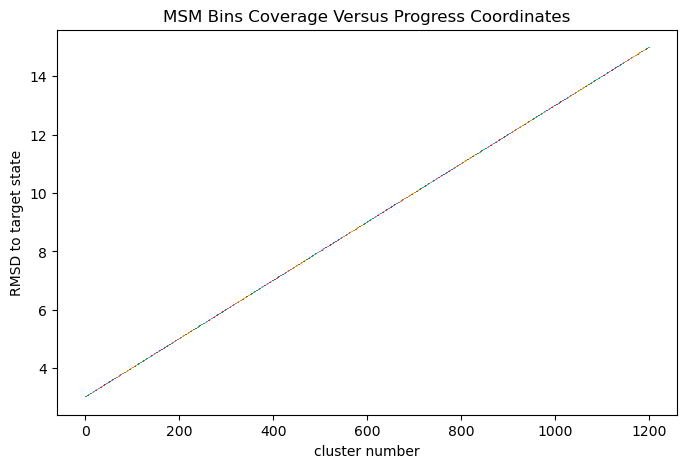

In [35]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 5]
# len-2 because the last two are NaN (eq simulation; target/basis states)
for idx in range(0,len(array)-2):
    plt.errorbar(idx, array[idx,0],yerr=[[0],[array[idx,1]-array[idx,0]]])
    #plt.plot(idx, array[idx,1], 'ro')
plt.xlabel('cluster number')
plt.ylabel('RMSD to target state')
plt.title('MSM Bins Coverage Versus Progress Coordinates')

[02/12/24 05:37:32] CRITICAL No cross-validation models have been generated! Do this before making ]8;id=688123;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=354732;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_plotting.py#280\280]8;;\
                             plots.                                                                                

                    INFO     Fluxes have not yet been generated for main_model, generating now.    ]8;id=431406;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=379922;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_plotting.py#312\312]8;;\

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=378150;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=65891;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_analysis.py#403\403]8;;\
                             currently built in to the code.                                                       

[02/12/24 05:39:14] WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=822261;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=591325;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_analysis.py#462\462]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=60959;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=232126;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_plotting.py#422\422]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

<Axes: xlabel='Pcoord 0', ylabel='Flux (weight/second)'>

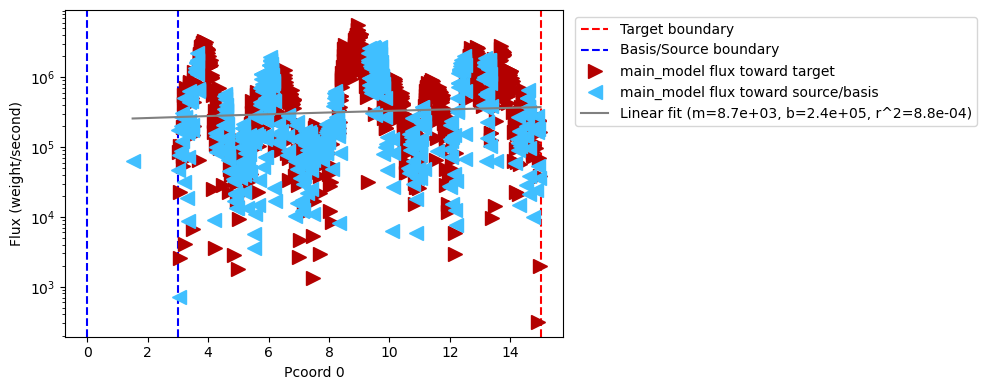

In [36]:
model.plot_flux(suppress_validation=True)

##### Although that's useful, plotting against progress coordinate may be misleading, since the transition region may not be evenly distributed in progress coordinate space.
##### To see if that's the case, let's look at the committor vs progress coordinate for our clusters.
##### The committor is 1 at the target state, and 0 at the source. So by looking at this plot, and seeing where the committor starts to break away from 0, we can get an idea of where the transition region is.
##### If you had a "perfect" progress coordinate, this would be a diagonal line.

In [37]:
model.get_committor()

[02/12/24 05:39:24] INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=487795;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=269870;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_analysis.py#642\642]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

  0%|          | 0/5.0 [00:00<?, ?it/s]

[02/12/24 05:39:28] INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=19222;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=120965;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_analysis.py#642\642]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

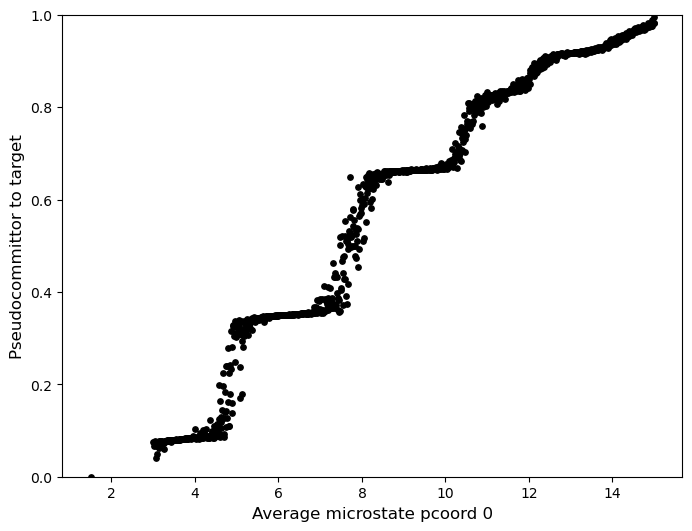

In [38]:
model.plot_committor()
#plt.gca().set_yscale('linear')
#plt.gca().axhline(y = 0.5, color = 'r', linestyle = '-') 

In [39]:
model.targetRMSD_centers.shape, model.q.shape

((1202, 1), (1202,))

In [61]:
plt.style.use('custom.mplstyle')

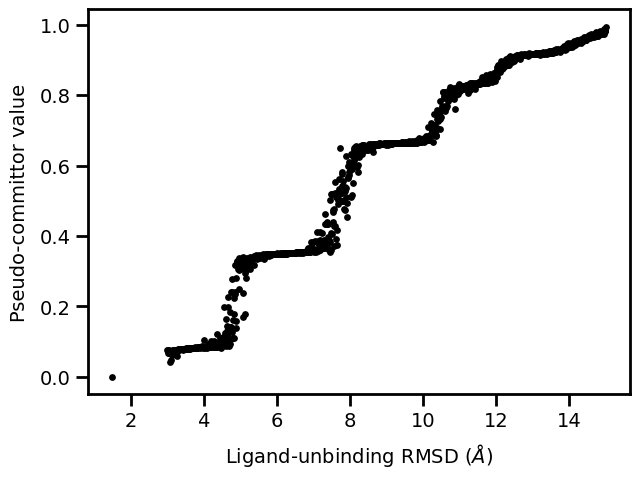

In [64]:
plt.figure()
plt.scatter(model.targetRMSD_centers[:,0], model.q, s=15, c="black")
plt.ylabel("Pseudo-committor value")
plt.xlabel("Ligand-unbinding RMSD ($\AA$)")
plt.savefig("HIF2a_s1_e1000committor.png", bbox_inches = "tight")

[02/12/24 05:33:38] CRITICAL No cross-validation models have been generated! Do this before making ]8;id=497937;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=459541;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_plotting.py#118\118]8;;\
                             plots.                                                                                

                    INFO     Committor-fluxes have not yet been generated for main_model,          ]8;id=531606;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=415352;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_plotting.py#153\153]8;;\
                             generating now.                                                                       

Obtaining pseudocommittor-fluxes:   0%|          | 0/901 [00:00<?, ?it/s]

[02/12/24 05:34:27] INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=280387;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=133068;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_analysis.py#642\642]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

                    WARNING  Flux profile appears to be overcorrected! In other words, the flux    ]8;id=524250;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=252911;file:///home/marion_lab/Apps/msm_we/msm_we/_hamsm/_plotting.py#422\422]8;;\
                             profile appears higher near the target than the basis. This suggests                  
                             restarting may have driven the system past its true steady-state.                     
                             This WE run should be continued without restarting, and allowed to                    
                             relax.                                                                                

<Axes: xlabel='Pseudocommittor', ylabel='Flux (weight/second)'>

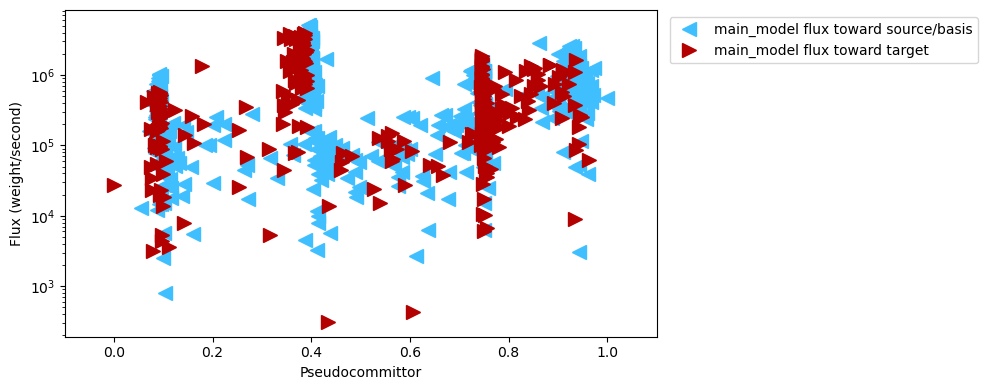

In [20]:
model.plot_flux_committor(suppress_validation=True)
#plt.gca().set_xscale('linear')
#plt.savefig('flux_pseudo_uneven_bin-restart34-t2-c18.png')

In [17]:
# For loading the clustered model data
#from pickle import load
#with open('NEW-MSMWE_clustering_scikit_c200_uneven_bin_heavy_step4-restart345-t2.pickle', 'rb') as fo:
#    model = load(fo)

In [18]:
## For saving the clustered model data
#from pickle import dump
#with open('NEW-MSMWE_clustering_scikit_c400_uneven_bin_heavy_step4-restart345-t3.pickle', 'wb') as fo:
#    dump(model, fo)

# Extract transition state (pseudo-committor of a certain range)

In [70]:
# Parsing through the list so we get the real seg number (and the file number as well)
from copy import deepcopy

def output_pseudocommittor(lower, upper, both):
    # Finding all the iter/seg_index
    output = []
    for j in range(0, len(model.dtrajs)):
        val = np.argwhere(np.isin(model.dtrajs[j], both))
        #print(j+1, np.squeeze(val,axis=1))
        output.append([j+1, np.squeeze(val, axis=1)])
    output2 = [[val[0], seg] for val in output for seg in val[1]]
    #output2

    file_list = []
    for file in model.fileList:
        with h5py.File(file,'r') as f:
            file_list.append(f['summary']['n_particles'])

    output3 = deepcopy(output2)

    for j in output3:
        seg_index = j[1]
        tol = 0
        for i in range(0,len(file_list)):
            tol += file_list[i][j[0]-1]
            #print(i, tol, seg_index)
            if seg_index < tol:
                #print('break')
                break
            #print(tol)
        if i != 0: 
            #print('here')
            tol -= file_list[i][j[0]-1]
            j[1] -= tol
        else:
            j[1] = seg_index
        j.insert(0,i+1)

    output3 = np.asarray(output3)
    #with open(f'transition_state_from{lower}_to{upper}.npy','wb') as fo:
    #    np.save(fo,output3)
    
    list=[]
    for i in range(output3.shape[0]):
        #print(output3[i,0])
        if(output3[i,0]==3):
            list.append(output3[i,:])
            
    output4 = np.asarray(list)
    
    list2=[]
    for i in range(output3.shape[0]):
        #print(output3[i,0])
        if(output3[i,0]=!3):
            list2.append(output3[i,:])
            
    output5 = np.asarray(list2)

    np.savetxt(f'transition_state_from{lower}_to{upper}.dat',output4, fmt="%d %d %d")
    np.savetxt(f'transition_state_from{lower}_to{upper}_C2.dat',output4, fmt="%d %d %d")

    print(output3.shape, output4.shape) #output3[:,0])

In [71]:
from tqdm.auto import tqdm
#ranges = [(0,0.2), (0.2,0.4),(0.4,0.6),(0.6,0.8),(0.8,1), (0,0.1),(0.1,0.2),(0.8,0.9),(0.9,1), 
#(0,0.3), (0.3,0.6),(0.6,1),(0.45,0.55)]
#ranges = [(0.4,0.6),(0.45,0.55)]
ranges = [(0.3,0.7),(0.4,0.6)]

# specify upper, lower range.
for val in tqdm(ranges):
    under = np.argwhere(model.q < val[1])
    over = np.argwhere(model.q > val[0])
    both = [i for [i] in under if i in over]
    #print(model.q[both])
    output_pseudocommittor(val[0],val[1],both)

  0%|          | 0/2 [00:00<?, ?it/s]

(173955, 3) (63167, 3)
(43865, 3) (16335, 3)


# Post-Featurization Steps

In [ ]:
model.do_block_validation(cross_validation_groups=2, cross_validation_blocks=8)#, skip=[1])

In [ ]:
from copy import deepcopy
do_block_validation(self=model, cross_validation_groups=2, cross_validation_blocks=8, use_ray=True)

In [ ]:
# For loading the clustered model data
from pickle import load
with open('clustering_scikit_c18_uneven_bin_heavy_step5-restart34-zero7.pickle', 'rb') as fo:
    model = load(fo)

In [ ]:
# For saving the clustered model data
from pickle import dump
with open('NEW-MSMWE_clustering_scikit_c200_uneven_bin_heavy_step5-restart345-t3.pickle', 'wb') as fo:
    dump(model, fo)

# Block Validation Rates

In [ ]:
for i in range(len(model.validation_models)):
    model.validation_models[i].get_steady_state_target_flux()

    print(f'Steady-state target rate is {model.validation_models[i].JtargetSS:.2e} for model {i}')

In [ ]:
import numpy
list_of_rates = [model.JtargetSS, model.validation_models[0].JtargetSS, model.validation_models[1].JtargetSS]
print(numpy.std(list_of_rates))
print(numpy.average(list_of_rates))

In [ ]:
for i in range(len(model.validation_models)):
    model.validation_models[i].get_steady_state_target_flux()

    print(f'Steady-state target rate is {model.validation_models[i].JtargetSS:.2e} for model {i}')

In [ ]:
import numpy
list_of_rates = [model.JtargetSS, model.validation_models[0].JtargetSS, model.validation_models[1].JtargetSS]
print(numpy.std(list_of_rates))
print(numpy.average(list_of_rates))

In [ ]:
ray.shutdown()

# Block Validation Output

In [ ]:
import weight_loop
for idx, v_model in enumerate(model.validation_models):
    if idx == 0:
        continue
    weight_loop.create_reweighted_h5_global(v_model,new_name=f'west_reweight_c10_block_to20_v2-try2_v{idx}.h5')

# Main model Output

In [ ]:
import weight_loop

weight_loop.create_reweighted_h5_global(model, west_name='west_nocoords.h5', copy=True, struct_filetype='ncrst', new_name=f'west_reweight.h5', gen_sstates=True, pdb_out=False, link_out=True, link_path="/ocean/projects/mcb180038p/jml230/bdpa_wsh2029_p3_r3",)

In [ ]:
import weight_loop

weight_loop.create_reweighted_h5_global(model, west_name='west_nocoords.h5', copy=True, struct_filetype='ncrst', new_name=f'west_restart345_reweight-vamp.h5', gen_sstates=False, pdb_out=False, link_out=False, link_path="/ocean/projects/mcb180038p/jml230/bdpa_wsh2029_p3_r3",)

# Extract transition state (pseudo-committor of a certain range)

In [ ]:
from copy import deepcopy
import numpy as np
import numpy
from tqdm.auto import tqdm
ranges = [(0,0.2), (0.2,0.4),(0.4,0.6),(0.6,0.8),(0.8,1), (0,0.1),(0.1,0.2),(0.8,0.9),(0.9,1), (0,0.3), (0.3,0.6),(0.6,1),(0.45,0.55)]
#ranges = [(0.4,0.6),(0.45,0.55)]
#ranges = [(0.35,0.45)]

# specify upper, lower range.
for val in tqdm(ranges):
    under = np.argwhere(model.q < val[1])
    over = np.argwhere(model.q > val[0])

    both = [i for [i] in under if i in over]
    both
    output_pseudocommittor(val[0],val[1],both)

In [ ]:
# Parsing through the list so we get the real seg number (and the file number as well)
from copy import deepcopy
import numpy

def output_validation_pseudocommittor(lower, upper, both, x):
    # Finding all the iter/seg_index
    output = []
    for j in range(0, len(model.validation_models[x].dtrajs)):
        val = numpy.argwhere(numpy.isin(model.validation_models[x].dtrajs[j], both))
        #print(j+1, numpy.squeeze(val,axis=1))
        output.append([j+1, numpy.squeeze(val, axis=1)])
    #print(output)
    output2 = [[val[0], seg] for val in output for seg in val[1] if val[0] in model.validation_iterations[x]]
    print(output2)

    file_list = []
    for file in model.fileList:
        with h5py.File(file,'r') as f:
            file_list.append(f['summary']['n_particles'])

    #print(file_list)
    output3 = deepcopy(output2)

    for j in output3:
        seg_index = j[1]
        tol = 0
        for i in range(0,len(file_list)):
            tol += file_list[i][j[0]-1]
            #print(i, tol, seg_index)
            if seg_index < tol:
                #print('break')
                break
            #print(tol)
        if i != 0: 
            #print('here')
            tol -= file_list[i][j[0]-1]
            j[1] -= tol
        else:
            j[1] = seg_index
        j.insert(0,i+1)

    output3 = numpy.asarray(output3)
    with open(f'transition_state/validation_models/transition_state_validation{x}_{lower}to{upper}.npy','wb') as fo:
        numpy.save(fo,output3)
    output3

In [ ]:
from copy import deepcopy
import numpy as np
import numpy
from tqdm.auto import tqdm,trange
ranges = [(0,0.2), (0.2,0.4),(0.4,0.6),(0.6,0.8),(0.8,1), (0,0.1),(0.1,0.2),(0.8,0.9),(0.9,1), (0,0.3), (0.3,0.6),(0.6,1),(0.45,0.55)]
#ranges = [(0.4,0.6),(0.45,0.55),(0.35,0.45)]
# ranges = [(0.45,0.55)]

# specify upper, lower range.
for j in trange(len(model.validation_models)):
    for val in tqdm(ranges):
        under = np.argwhere(model.validation_models[j].q < val[1])
        over = np.argwhere(model.validation_models[j].q > val[0])

        both = [i for [i] in under if i in over]
        print(both)
        output_validation_pseudocommittor(val[0],val[1],both,j)

In [ ]:
# OLDER VERSIONS

In [ ]:
from copy import deepcopy
import numpy as np
import numpy
from tqdm.auto import tqdm
ranges = [(0.45,0.55),(0,0.2), (0.2,0.4),(0.4,0.6),(0.6,0.8),(0.8,1), (0,0.1),(0.1,0.2),(0.8,0.9),(0.9,1), (0,0.3), (0.3,0.6),(0.6,1)]

# specify upper, lower range.
for val in tqdm(ranges):
    under = np.argwhere(model.q < val[1])
    over = np.argwhere(model.q > val[0])

    both = [i for [i] in under if i in over]
    both
    output_pseudocommittor(val[0],val[1],both)

In [ ]:
ray.shutdown()

In [ ]:
# Parsing through the list so we get the real seg number (and the file number as well)
from copy import deepcopy
import numpy

def output_pseudocommittor(lower, upper, both):
    # Finding all the iter/seg_index
    output = []
    for j in range(0, len(model.dtrajs)):
        val = numpy.argwhere(numpy.isin(model.dtrajs[j], both))
        #print(j+1, numpy.squeeze(val,axis=1))
        output.append([j+1, numpy.squeeze(val, axis=1)])
    output2 = [[val[0], seg] for val in output for seg in val[1]]
    #output2

    file_list = []
    for file in model.fileList:
        with h5py.File(file,'r') as f:
            file_list.append(f['summary']['n_particles'])

    output3 = deepcopy(output2)

    for j in output3:
        seg_index = j[1]
        tol = 0
        for i in range(0,len(file_list)):
            tol += file_list[i][j[0]-1]
            #print(i, tol, seg_index)
            if seg_index < tol:
                #print('break')
                break
            #print(tol)
        if i != 0: 
            #print('here')
            tol -= file_list[i][j[0]-1]
            j[1] -= tol
        else:
            j[1] = seg_index
        j.insert(0,i+1)

    output3 = numpy.asarray(output3)
    with open(f'transition_state/transition_state_{lower}to{upper}.npy','wb') as fo:
        numpy.save(fo,output3)
    output3

In [ ]:
# Double check to see that I didn't do something odd
numpy.argwhere(output3<0)

# Plotting and Stuff

In [ ]:
# Lets get the list of file all here
listf = []
for idx in range(1,6):
    #listf.append(f"restart0_scikit_nowat/run{idx}/west_reweight_c10_block_to20_v2-try2_v0.h5")
    listf.append(f"restart0_scikit_nowat/run{idx}/west_reweight_c10_block_to20_v2-try2_v1.h5")
    #listf.append(f"restart0_scikit_nowat/run{idx}/west_reweight_c10_block_to20_v2.h5")
    
file_path = listf[0].rsplit('.',maxsplit=1)[0]
print(file_path)

In [ ]:
# Generating the cool text file
import numpy
from tqdm.auto import tqdm

aux = 'RoG'

with open(f'{file_path}_RoG_iter.dat', 'w') as g:
    for idx, stuff in enumerate(listf):
        f = h5py.File(stuff, 'r')
        for i in tqdm(range(1,301), desc=f"File {idx+1}"): # change indices to number of iteration
            i = str(i)
            iteration = "iter_" + str(numpy.char.zfill(i,8))
            s = f['iterations'][iteration]['seg_index'].shape[0]
            r1 = f['iterations'][iteration]['auxdata'][aux][:,-1] # These are the auxillary coordinates you're looking for
            r2 = f['iterations'][iteration]['seg_index']['weight'][:] # These are the auxillary coordinates you're looking for
            for j in range(0,s):
                array1=[]
                array1 = r2 # Weights normalized across whole simulation
                g.write(str(array1[j]) + "\t" + str(r1[j]) + "\n")

In [ ]:
# Loading Data
import numpy
block_new0_wt, block_new0_data = numpy.loadtxt('restart0_scikit_nowat/run1/west_reweight_c10_block_to20_v2_v0_RoG_iter.dat',usecols=(0,1), unpack=True)
block_new1_wt, block_new1_data = numpy.loadtxt('restart0_scikit_nowat/run1/west_reweight_c10_block_to20_v2-try2_v1_RoG_iter.dat',usecols=(0,1), unpack=True)
block_main_wt, block_main_data = numpy.loadtxt('restart0_scikit_nowat/run1/west_reweight_c10_block_to20_v2_RoG_iter.dat',usecols=(0,1), unpack=True)

global_wt, global_data = numpy.loadtxt('restart0_scikit_nowat/run1/wsh2045_reweight_global_rmsheavy_iter.dat',usecols=(0,1), unpack=True)
raw_wt, raw_data = numpy.loadtxt( 'restart0_scikit_nowat/run1/wsh2045_reweight_rmsheavy_iter.dat',usecols=(0,1), unpack=True)

In [ ]:
block_new0b_wt, block_new0b_data = numpy.loadtxt('restart0_scikit_nowat/run1/west_reweight_c10_block_v0b_mod_rmsheavy_iter.dat',usecols=(0,1), unpack=True)
block_new1b_wt, block_new1b_data = numpy.loadtxt('restart0_scikit_nowat/run1/west_reweight_c10_block_v1b_mod_rmsheavy_iter.dat',usecols=(0,1), unpack=True)

In [ ]:
# Colors and Labels and other parameters
import matplotlib
import matplotlib.pyplot as plt
wsh2045color = (0,0,0,1)
wsh2029color = (0.867,0.317,0.5098,1)
wsh2036color = (1,0.431,0.32994,1)
wsh2057color = (1,0.651,0,1)
wsh2044color = (0.267,0.306,0.525,1)
wsh2054color = (0.584,0.3176,0.588,1)
colors = [wsh2045color, wsh2054color, wsh2029color, wsh2057color, wsh2044color, wsh2054color]
#data = [raw_wt, global_wt, block_main_wt, block_new0_wt, block_new1_wt]
plt.rcParams.update({'figure.figsize': [4.5,4.5], 'font.size': 17.5, 'figure.dpi': 300, 'font.family': 'Arial',
                     'ytick.major.width': 2, 'xtick.major.width': 2, 'axes.linewidth': 2})
labels = [u'Raw', u'Old, Global Aggregated', u'New Stratified Model', u'New Stratified Validation Model 0', u'New Stratified Validation Model 1']
transparency=[1,1,0.25,0.5, 0.5]

In [ ]:
# For the Legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[1], alpha=transparency[1], lw=4),
                Line2D([0], [0], color=colors[2], alpha=transparency[0], lw=4),
                Line2D([0], [0], color=colors[3], alpha=transparency[3], lw=4),
                Line2D([0], [0], color=colors[4], alpha=transparency[4], lw=4),
                Line2D([0], [0], color=colors[0], alpha=transparency[0], lw=4),]

labels = [u'all data',
          'block 1',
          u'block 2',
          'run 4',
          u'run 5']

In [ ]:
# Everything
for i,dataset in enumerate(data):
    plt.hist(dataset,bins=100, color=colors[i], range=(0,0.001), histtype='bar', log=True, alpha=transparency[i], label=labels[i])
plt.legend()
plt.title('Distribution of Weights');
plt.savefig('new_stratified_c10_plots/all_weight_dist.png',dpi=300)

In [ ]:
# Before Reweighting
plt.hist(data[0], bins=300, color=colors[0], range=(0,0.001),log=True)
plt.title(labels[0]);
plt.xlabel('Weights')
plt.ylabel('Counts')
plt.savefig('new_stratified_c10_plots/raw_weight_dist.png', dpi=300)

In [ ]:
# Global Reweighting (Way before Stratified)
plt.hist(data[1], bins=300, color=colors[1], range=(0,0.001), log=True)
plt.title(labels[1])
plt.xlabel('Weights')
plt.ylabel('Counts')
plt.savefig('new_stratified_c10_plots/old_global_dist.png',dpi=300)

In [ ]:
# New Stratified Main Model Reweighting
plt.hist(data[2], bins=300, color=colors[2], range=(0,0.001), log=True)
plt.title(labels[2])
plt.xlabel('Weights')
plt.ylabel('Counts')
plt.savefig('new_stratified_c10_plots/new_main_model_dist.png',dpi=300)

In [ ]:
# New Stratified Validation Model 0 Reweighting
plt.hist(data[3], bins=300, color=colors[3], range=(0,0.001), log=True)
plt.title(labels[3])
plt.xlabel('Weights')
plt.ylabel('Counts')
plt.savefig('new_stratified_c10_plots/new_model_v0_dist.png',dpi=300)

In [ ]:
# New Stratified Validation Model 1 Reweighting
plt.hist(data[4], bins=300, color=colors[4], range=(0,0.001), log=True)
plt.title(labels[4])
plt.xlabel('Weights')
plt.ylabel('Counts')
plt.savefig('new_stratified_c10_plots/new_model_v1_dist.png',dpi=300)

In [ ]:
# Block Reweighting (Main Model + Validation Sets 0 + 1)
plt.hist(block_main_wt, bins=300, color=colors[0], range=(0,0.001), log=True, label=labels[2], 
         alpha=transparency[3])
plt.hist(block_new0_wt, bins=300, color=colors[3], range=(0,0.001), log=True, label=labels[3], 
         alpha=transparency[3])
plt.hist(block_new1_wt, bins=300, color=colors[4], range=(0,0.001), log=True, label=labels[4], 
         alpha=transparency[4])
plt.legend()
plt.xlabel('probability weights')
plt.ylabel('counts')
plt.title(u'Block Reweighted (Main + Validation Sets 0 + 1)');
#plt.savefig('new_stratified_c10_plots/new_model_all_dist.png',dpi=300)

In [ ]:
# Block Reweighting (Everything)

plt.hist(raw_data, bins=100, color=colors[0], histtype='step', weights=raw_wt, label=labels[0])
#plt.hist(global_data, bins=100, color=colors[1], histtype='step', weights=global_wt, label=labels[1])
plt.hist(block_main_data, bins=100, color=colors[2], weights=block_main_wt, label=labels[2])
plt.hist(block_new0_data, bins=100, color=colors[3], histtype = 'step', weights=block_new0_wt, label='Validation Model 0')
plt.hist(block_new1_data, bins=100, color=colors[4], histtype = 'step', weights=block_new1_wt, label='Validation Model 1')

plt.title(u'RMSD to Folded State');
plt.legend()
plt.xlabel(u'RMSD to folded state (\u212B)')
plt.ylabel('probability weights')
plt.savefig('new_stratified_c10_plots/new_model_rmsd_heavy_dist.png',dpi=300)


In [ ]:
# Just the main + validation models
plt.hist(block_main_data, bins=100, range=(11,18), color=colors[2], histtype = 'step', weights=block_main_wt, label=labels[2])
plt.hist(block_new0_data, bins=100, range=(11,18), color=colors[3], histtype = 'step', weights=block_new0_wt, label='Validation Model 0')
plt.hist(block_new1_data, bins=100, range=(11,18), color=colors[4], histtype = 'step', weights=block_new1_wt, label='Validation Model 1')

#plt.title(u'RMSD to Folded State, Comparison with Same Cluster Models');
#plt.legend()
#plt.xlabel(u'RMSD to folded state (\u212B)')
#plt.ylabel('probability weights')
plt.ylabel('probability')
plt.xlabel(r'$\it{Rg}$ (Å)')
plt.legend(custom_lines[1:4], labels[:3], frameon=False)
plt.tight_layout()
plt.savefig('RoG_block_comp_haMSM_runs.pdf',dpi=300)
plt.savefig('RoG_block_comp_haMSM_runs.png', dpi=300)
#plt.savefig('new_stratified_c10_plots/new_model_rmsd_heavy_main_dist.png',dpi=300)

In [ ]:
# Just the main + validation models
plt.hist(block_main_data, bins=100, range=(11,17), color=colors[2], histtype = 'step', weights=block_main_wt, label=labels[2])
plt.hist(block_new0_data, bins=100, range=(11,17), color=colors[3], histtype = 'step', weights=block_new0_wt, label='Validation Model 0')
plt.hist(block_new1_data, bins=100, range=(11,17), color=colors[4], histtype = 'step', weights=block_new1_wt, label='Validation Model 1')

plt.title(u'RMSD to Folded State, Comparison with Same Cluster Models');
plt.legend()
plt.xlabel(u'RMSD to folded state (\u212B)')
plt.ylabel('probability weights')
#plt.savefig('new_stratified_c10_plots/new_model_rmsd_heavy_main_dist.png',dpi=300)

In [ ]:
plt.hist(block_main_data, bins=100, color=colors[2], weights=block_main_wt, label='Main Model')
plt.hist(block_new0b_data, bins=100, color=colors[3], histtype = 'step', weights=block_new0b_wt, label='Validation Model 0b')
plt.hist(block_new1b_data, bins=100, color=colors[4], histtype = 'step', weights=block_new1b_wt, label='Validation Model 1b')

plt.title(u'RMSD to Folded State, Comparison with Reclustered Models');
plt.legend()
plt.xlabel(u'RMSD to folded state (\u212B)')
plt.ylabel('probability weights')
plt.savefig('new_stratified_c10_plots/new_model_rmsd_heavy_main_dist2.png',dpi=300)

In [ ]:
import numpy
import matplotlib.pyplot as plt
block_main_sasa_wt, block_main_sasa = numpy.loadtxt('restart0_scikit_nowat/run1/west_reweight_c10_block_mod_totalSASA_iter.dat',usecols=(0,1), unpack=True);
block_2029_sasa_wt, block_2029_sasa = numpy.loadtxt('../bdpa_wsh2029_p2_haMSM/restart0_scikit_nowat/run1/west_reweight_c10_block_totalSASA_iter.dat',usecols=(0,1), unpack=True);

plt.hist(block_main_sasa, bins=100, color=colors[0], histtype='step', weights=block_main_sasa_wt, label='WT')
plt.hist(block_2029_sasa, bins=100, color=colors[1], histtype='step', weights=block_2029_sasa_wt, label='\u03B2\u00B3 H2')
plt.title(u'Total SASA');
plt.legend()
plt.xlabel(u'Total SASA (\u212B\u00B2)')
plt.ylabel('probability weights')
plt.savefig('new_stratified_c10_plots/new_model_totalSASA_main_dist.png',dpi=300)

In [ ]:
import numpy
import matplotlib.pyplot as plt
block_main_RoG_wt, block_main_RoG = numpy.loadtxt('restart0_scikit_nowat/run1/west_reweight_c10_block_mod_RoG_iter.dat',usecols=(0,1), unpack=True);
block_2029_RoG_wt, block_2029_RoG = numpy.loadtxt('../bdpa_wsh2029_p2_haMSM/restart0_scikit_nowat/run1/west_reweight_c10_block_RoG_iter.dat',usecols=(0,1), unpack=True);


plt.hist(block_main_RoG, bins=100, color=colors[0], histtype = 'step', weights=block_main_RoG_wt, label='WT')
plt.hist(block_2029_RoG, bins=100, color=colors[1], histtype = 'step', weights=block_2029_RoG_wt, label=u'\u03B2\u00B3 H2')
plt.title(u'Radius of Gyration');
plt.legend()
plt.xlabel(u'RoG (\u212B)')
plt.ylabel('probability weights')
plt.savefig('new_stratified_c10_plots/new_model_RoG_main_dist.png',dpi=300)

In [ ]:
import numpy
import matplotlib.pyplot as plt
block_main_pCH_wt, block_main_pHC = numpy.loadtxt('restart0_scikit_nowat/run1/west_reweight_c10_block_mod_percentContacts_iter.dat',usecols=(0,1), unpack=True);
block_2029_pHC_wt, block_2029_pHC = numpy.loadtxt('../bdpa_wsh2029_p2_haMSM/restart0_scikit_nowat/run1/west_reweight_c10_block_percentContacts_iter.dat',usecols=(0,1), unpack=True);

plt.hist(block_main_pHC, bins=100, color=colors[0], histtype = 'step', weights=block_main_RoG_wt, label='WT')
plt.hist(block_2029_pHC, bins=100, color=colors[1], histtype = 'step', weights=block_2029_pHC_wt, label=u'\u03B2\u00B3 H2')
plt.title(u'Percent of Native Contacts');
plt.legend()
plt.xlabel(u'Percent of Native Contacts')
plt.ylabel('probability weights')
plt.savefig('new_stratified_c10_plots/new_model_percentContacts_main_dist.png',dpi=300)

In [ ]:
import numpy
import matplotlib.pyplot as plt
block_main_pCH_wt, block_main_pHC = numpy.loadtxt('restart0_scikit_nowat/run1/west_reweight_c10_block_to20_rms_iter.dat',usecols=(0,1), unpack=True);
block_main_pCH_wt2, block_main_pHC2 = numpy.loadtxt('restart0_scikit_nowat/run1/west_reweight_c10_block_rms_iter.dat',usecols=(0,1), unpack=True);
raw_wt, raw_data = numpy.loadtxt( 'restart0_scikit_nowat/run1/wsh2045_reweight_rmsheavy_iter.dat',usecols=(0,1), unpack=True)

plt.hist(block_main_pHC, bins=100, color=colors[0], histtype = 'step', weights=block_main_pCH_wt, label='WT-extended bins')
plt.hist(block_main_pHC2, bins=100, color=colors[1], histtype = 'step', weights=block_main_pCH_wt2, label='old WT')
plt.hist(raw_data, bins=100, color=colors[3], histtype = 'step', weights=raw_wt, label='Raw')
plt.title(u'RMSD to folded state');
plt.legend()
plt.xlabel(u'RMSD to folded state')
plt.ylabel('probability weights')
#plt.savefig('new_stratified_c10_plots/new_model_percentContacts_main_dist.png',dpi=300)

In [ ]:
import numpy
import matplotlib.pyplot as plt
block_main_pCH_wt, block_main_rms = numpy.loadtxt('restart0_scikit_nowat/run1/west_reweight_c10_block_to20_v2_rms_iter.dat',usecols=(0,1), unpack=True);
block_main_pCH_wt, block_main_rms_0b = numpy.loadtxt('west_reweight_c10_block_to20_v2_v0b_rms_iter.dat',usecols=(0,1), unpack=True);
block_main_pCH_wt2, block_main_pHC2 = numpy.loadtxt('west_reweight_c10_block_to20_v2_v1b_rms_iter.dat',usecols=(0,1), unpack=True);
raw_wt, raw_data = numpy.loadtxt( 'restart0_scikit_nowat/run1/wsh2045_reweight_rmsheavy_iter.dat',usecols=(0,1), unpack=True)

plt.hist(block_main_pHC, bins=100, color=colors[0], histtype = 'step', weights=block_main_pCH_wt, label='WT-extended bins')
plt.hist(block_main_pHC2, bins=100, color=colors[1], histtype = 'step', weights=block_main_pCH_wt2, label='old WT')
plt.hist(raw_data, bins=100, color=colors[3], histtype = 'step', weights=raw_wt, label='Raw')
plt.title(u'RMSD to folded state');
plt.legend()
plt.xlabel(u'RMSD to folded state')
plt.ylabel('probability weights')
#plt.savefig('new_stratified_c10_plots/new_model_percentContacts_main_dist.png',dpi=300)

In [ ]:
model.fluxMatrix

In [ ]:
model.Tmatrix[0,1]

In [ ]:
model.Tmatrix[1,0]


In [ ]:
import pyemma
import msmtools
import numpy

In [ ]:
sym_matrix = (model.Tmatrix.T + model.Tmatrix) 
sym_matrix = sym_matrix/sym_matrix.sum(axis=1, keepdims=1)
msmtools.analysis.is_transition_matrix(sym_matrix)

In [ ]:
import pyemma
import msmtools
pcca_model = pyemma.msm.markov_model(sym_matrix,'100 ps')
pcca_model.is_reversible = True

In [ ]:
pcca_model

In [ ]:
nstates=10
pcca_model.pcca(nstates)

In [ ]:
pcca_model._metastable_memberships[0]

# Now to test new things

In [ ]:
import weight_loop
weight_loop.create_reweighted_h5_global(model,new_name='west_reweight_block_new.h5')

# TROUBLE SHOOTING

In [ ]:
model.get_eqTmatrix()
model.Tmatrix.shape

In [ ]:
model.indBasis, model.indTargets = np.array([]),np.array([])

In [ ]:
model.pSS

In [ ]:
model.Tmatrix.shape


In [ ]:
model.Tmatrix[-1]


In [ ]:
model.Tmatrix[0]

In [ ]:
import numpy
a = []
for w in range(0,len(model.dtrajs)):
    a = numpy.append(a, model.dtrajs[w])

for z in range(0,131):
    if z not in a:
        print(z)